# Chapter 9. Unsupervised Learning Techniques



In [89]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

np.random.seed(0)

plt.style.use('seaborn-whitegrid')

In [90]:
%matplotlib inline

In [91]:
# %load_ext ipycache

This chapter covers the following unsupervised learning techniques: clustering, anomaly detection, and density estimation.

## Clustering

*Clustering* is the task of identifying similar instances and assigning them to groups.

The author discusses some useful tasks for clustering:

1. At the beginning of a data analysis, the data can be clustered and then each cluster can be analyzed separately.
2. Once clusters have been assigned, the affinity values for each cluster can be used for dimensionality reduction.
3. Anomalies can be detected as those that don't fit into a cluster.
4. Label propagation from labeled data to new unlabeled data for semi-supervised learning.

### K-means

Below is an example of K-means clustering on artificial data made of blobs.

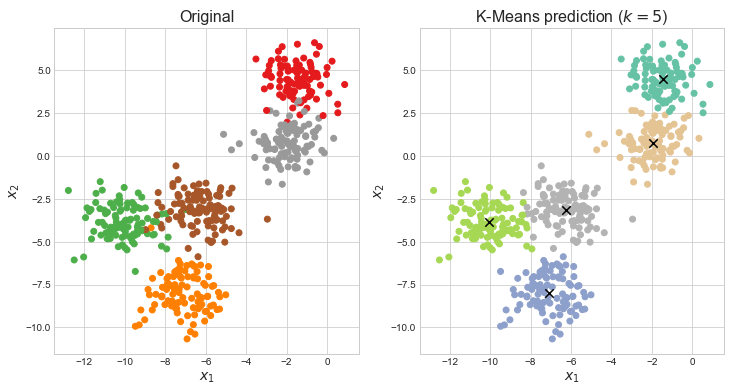

In [92]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

# Artifical data.
X, y = make_blobs(n_samples=500, centers=5, random_state=1)

# K-means clustering.
k = 5  # The number of clusters to find.
kmeans = KMeans(n_clusters=k)
kmeans.fit(X)

# Make classifications from K-means model.
y_pred = kmeans.predict(X)


# Plotting.
fig = plt.figure(figsize=(12, 6))

# Plot the original clusters.
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='Set1')
plt.xlabel('$x_1$', fontsize=14)
plt.ylabel('$x_2$', fontsize=14)
plt.title('Original', fontsize=16)

# Plot the K-means classifications.
plt.subplot(1, 2, 2)
plt.scatter(X[:, 0], X[:, 1], c=y_pred, cmap='Set2')
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], c='k', s=70, marker='x')

plt.xlabel('$x_1$', fontsize=14)
plt.ylabel('$x_2$', fontsize=14)
plt.title(f'K-Means prediction ($k={k}$)', fontsize=16)
plt.show()

In [93]:
# Show the centers of the clusters.
kmeans.cluster_centers_

array([[ -1.4648927 ,   4.48324949],
       [ -7.06987369,  -8.00398029],
       [-10.06803235,  -3.86080028],
       [ -1.94678228,   0.75595381],
       [ -6.25834345,  -3.13587364]])

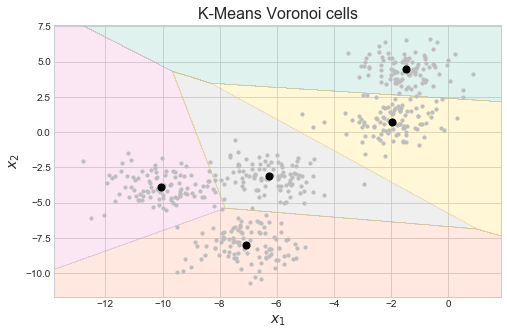

In [94]:
# Create Voronoi cells by predicting over a mesh.
h = .02  # step size of the mesh grid.
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
x0, x1 = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
X_mesh = np.c_[x0.ravel(), x1.ravel()]
y_pred = kmeans.predict(X_mesh).reshape(x0.shape)

# Plot Voronoi cells.
fig = plt.figure(figsize=(8, 5))

plt.contourf(x0, x1, y_pred, cmap='Set2', alpha=0.2)

plt.scatter(X[:, 0], X[:, 1], c='#bdbdbd', s=10)

plt.scatter(centroids[:, 0], centroids[:, 1], c='k', s=200, marker='.')

plt.xlabel('$x_1$', fontsize=14)
plt.ylabel('$x_2$', fontsize=14)
plt.title(f'K-Means Voronoi cells', fontsize=16)
plt.show()